In [1]:
!pip install torch torchvision

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
use_cuda = False
device = torch.device('cuda' if use_cuda else 'cpu')

In [3]:
# Default parameters from the PyTorch MNIST example (https://github.com/pytorch/examples/blob/master/mnist/main.py
params = dict(batch_size=64, batch_size_eval=1000, num_epochs=30, learning_rate=0.01, momentum=0.5)

# Load data

In [5]:
image_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

raw_train_dataset = datasets.MNIST('data', train=True, download=True, transform=image_transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=image_transform)

# Split 5k samples from the train dataset for validation (similar to Sacramento et al. 2018).
# TODO: Maybe seed this? Cannot be done in the method directly, so would need to manually call torch.seed. 
train_dataset, val_dataset = torch.utils.data.dataset.random_split(raw_train_dataset, (55000, 5000))

kwargs = {'num_workers': 3, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=params['batch_size_eval'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=params['batch_size_eval'], shuffle=False, **kwargs)

Processing...
Done!


## Make noisy test dataset

In [6]:
from PIL import Image

class AddGaussianNoise(object):
    def __init__(self, mean=0, std=64, scaling_factor=0.5):
        self.mean = mean
        self.std = std
        self.scaling_factor = scaling_factor
    
    def __call__(self, img):
        img_array = np.asarray(img)
        noisy_img_array = img_array + self.scaling_factor * np.random.normal(self.mean, self.std, img_array.shape)
        noisy_img_array = np.clip(noisy_img_array, 0, 255)
        noisy_img_array = noisy_img_array.astype(img_array.dtype)
        return Image.fromarray(noisy_img_array)
        
    def __repr__(self):
        return self.__class__.__name__ + '(mean={}, std={}, scaling_factor={})'.format(self.mean, self.std, self.intensity)

In [8]:
image_transform = transforms.Compose([
                       AddGaussianNoise(scaling_factor=2),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

noisy_test_dataset = datasets.MNIST('data', train=False, download=True, transform=image_transform)
noisy_test_loader = torch.utils.data.DataLoader(noisy_test_dataset, batch_size=params['batch_size_eval'], shuffle=False, **kwargs)

## Make sequential dataset

In [5]:
num_allowed_seqs = 10
seq_len = 5

allowed_seqs = np.random.randint(0, 10, (num_allowed_seqs, seq_len))

In [6]:
import random

class ImageSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, allowed_seqs, image_dataset, num_classes):
        self.allowed_seqs = allowed_seqs
        self.images_per_class = {i: [] for i in range(num_classes)}
        for image, class_ in train_dataset:
            self.images_per_class[class_.item()].append(image)
        
    def __len__(self):
        return len(allowed_seqs)
    
    def __getitem__(self, i):
        images = [random.choice(self.images_per_class[class_]) for class_ in allowed_seqs[i]]
        return torch.cat(images), allowed_seqs[i]

In [7]:
def plot_image_sequence(images, targets):
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(targets[i])

In [8]:
seq_train_dataset = ImageSequenceDataset(allowed_seqs, train_dataset, 10)
seq_test_dataset = ImageSequenceDataset(allowed_seqs, test_dataset, 10)

seq_train_loader = torch.utils.data.DataLoader(seq_train_dataset, batch_size=params['batch_size'], shuffle=True, **kwargs)
seq_test_loader = torch.utils.data.DataLoader(seq_test_dataset, batch_size=params['batch_size_eval'], shuffle=False, **kwargs)

KeyboardInterrupt: 

In [0]:
seq_train_dataset[0][0].shape

torch.Size([5, 28, 28])

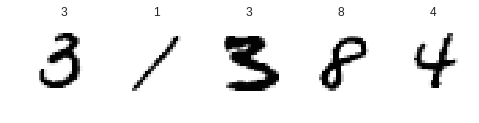

In [0]:
plot_image_sequence(*seq_train_dataset[0])

In [0]:
for data, target in seq_train_loader:
    print(data.shape, target.shape)

torch.Size([10, 5, 28, 28]) torch.Size([10, 5])


# Networks

In [9]:
class FeedforwardNet(nn.Module):
    # TODO: Add ability to easily add more hidden layers. 
    def __init__(self, num_hidden=500, dropout=0.5):
        super(FeedforwardNet, self).__init__()
        self.forward1 = nn.Linear(784, num_hidden)
        self.forward2 = nn.Linear(num_hidden, 10)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.forward1(x))
        x = self.dropout(x)
        x = self.forward2(x)
        # TODO: Maybe change to loss function that includes softmax. 
        return F.log_softmax(x, dim=1)

In [10]:
class FeedbackNet(nn.Module):
    def __init__(self, num_hidden=500, dropout=0.5):
        super(FeedbackNet, self).__init__()
        self.forward1 = nn.Linear(784, num_hidden)
        self.forward2 = nn.Linear(num_hidden, 10)
        self.dropout = nn.Dropout(dropout)
        
        self.feedback1 = nn.Linear(num_hidden, 784)
        self.feedback2 = nn.Linear(10, num_hidden)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        inp = inp.view(-1, 784)
        
        x = F.relu(self.forward1(inp))
        feedback_activation_1 = self.feedback1(x)
        
        x = self.dropout(x)
        x = F.log_softmax(self.forward2(x), dim=1)
        feedback_activation_2 = self.feedback2(x)
        # TODO: Maybe change to loss function that includes softmax. 
        
        #print(feedback_activation_1.shape, feedback_activation_2.shape)
        
        # 2nd forward pass, this time with added feedback
        x = F.relu(self.forward1(inp + feedback_activation_1))
        # TODO: Do dropout again here or only on the first pass?
        #x = F.dropout(x, training=self.training)
        x = F.log_softmax(self.forward2(x + feedback_activation_2), dim=1)
        
        return x
        

In [11]:
class ConvNet(nn.Module):
    """ConvNet from the official PyTorch tutorial, achieves around 98 % accuracy on test set (https://github.com/pytorch/examples/blob/master/mnist/main.py)."""
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Training

In [12]:
def train(model, device, train_loader, optimizer, epoch, params=None):
    model.train()
    for batch, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # TODO: Change to loss_function = ..., loss_function(output, target)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch * len(data), len(train_loader.dataset),
                100. * batch / len(train_loader), loss.item()))

In [13]:
def test(model, device, test_loader, params=None):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # TODO: Change to loss_function = ..., loss_function(output, target)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in filter(lambda p: p.requires_grad, model.parameters()) if p.requires_grad)

In [175]:
import time

#model = FeedforwardNet(num_hidden=500).to(device)
model = FeedbackNet().to(device)
print('Model has', count_parameters(model), 'trianable parameters')

# TODO: Maybe use Adam or Adadelta instead. 
optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'])

for epoch in range(params['num_epochs']):
    print('Epoch {}/{}'.format(epoch+1, params['num_epochs']))
    start_time = time.time()
    train(model, device, train_loader, optimizer, epoch+1)
    print('Took', time.time()-start_time, 'seconds')
    test(model, device, test_loader)
    print('Now testing on noisy dataset...')
    test(model, device, noisy_test_loader)

Model has 795794 trianable parameters
Epoch 1/30
Train Epoch: 1 [0/55000 (0%)]	Loss: 2.599647
Train Epoch: 1 [6400/55000 (12%)]	Loss: 0.433526
Train Epoch: 1 [12800/55000 (23%)]	Loss: 0.550520
Train Epoch: 1 [19200/55000 (35%)]	Loss: 0.409129
Train Epoch: 1 [25600/55000 (47%)]	Loss: 0.151310
Train Epoch: 1 [32000/55000 (58%)]	Loss: 0.220261
Train Epoch: 1 [38400/55000 (70%)]	Loss: 0.252231
Train Epoch: 1 [44800/55000 (81%)]	Loss: 0.085708
Train Epoch: 1 [51200/55000 (93%)]	Loss: 0.210743
Took 11.529579877853394 seconds

Test set: Average loss: 0.1694, Accuracy: 9469/10000 (95%)

Now testing on noisy dataset...

Test set: Average loss: 0.9910, Accuracy: 6377/10000 (64%)

Epoch 2/30
Train Epoch: 2 [0/55000 (0%)]	Loss: 0.192741
Train Epoch: 2 [6400/55000 (12%)]	Loss: 0.180095
Train Epoch: 2 [12800/55000 (23%)]	Loss: 0.233141
Train Epoch: 2 [19200/55000 (35%)]	Loss: 0.083444
Train Epoch: 2 [25600/55000 (47%)]	Loss: 0.157057
Train Epoch: 2 [32000/55000 (58%)]	Loss: 0.207071
Train Epoch: 2 [

Took 11.483542203903198 seconds

Test set: Average loss: 0.0635, Accuracy: 9797/10000 (98%)

Now testing on noisy dataset...

Test set: Average loss: 0.9088, Accuracy: 7395/10000 (74%)

Epoch 14/30
Train Epoch: 14 [0/55000 (0%)]	Loss: 0.014144
Train Epoch: 14 [6400/55000 (12%)]	Loss: 0.008342
Train Epoch: 14 [12800/55000 (23%)]	Loss: 0.033322
Train Epoch: 14 [19200/55000 (35%)]	Loss: 0.034618
Train Epoch: 14 [25600/55000 (47%)]	Loss: 0.015373
Train Epoch: 14 [32000/55000 (58%)]	Loss: 0.003172
Train Epoch: 14 [38400/55000 (70%)]	Loss: 0.008841
Train Epoch: 14 [44800/55000 (81%)]	Loss: 0.018476
Train Epoch: 14 [51200/55000 (93%)]	Loss: 0.027754
Took 11.93544602394104 seconds

Test set: Average loss: 0.0645, Accuracy: 9806/10000 (98%)

Now testing on noisy dataset...

Test set: Average loss: 0.9777, Accuracy: 7309/10000 (73%)

Epoch 15/30
Train Epoch: 15 [0/55000 (0%)]	Loss: 0.006222
Train Epoch: 15 [6400/55000 (12%)]	Loss: 0.058559
Train Epoch: 15 [12800/55000 (23%)]	Loss: 0.005951
Train

Train Epoch: 26 [25600/55000 (47%)]	Loss: 0.003082
Train Epoch: 26 [32000/55000 (58%)]	Loss: 0.019367
Train Epoch: 26 [38400/55000 (70%)]	Loss: 0.002328
Train Epoch: 26 [44800/55000 (81%)]	Loss: 0.022947
Train Epoch: 26 [51200/55000 (93%)]	Loss: 0.013302
Took 11.369554996490479 seconds

Test set: Average loss: 0.0672, Accuracy: 9825/10000 (98%)

Now testing on noisy dataset...

Test set: Average loss: 1.3636, Accuracy: 7114/10000 (71%)

Epoch 27/30
Train Epoch: 27 [0/55000 (0%)]	Loss: 0.001347
Train Epoch: 27 [6400/55000 (12%)]	Loss: 0.008940
Train Epoch: 27 [12800/55000 (23%)]	Loss: 0.002865
Train Epoch: 27 [19200/55000 (35%)]	Loss: 0.002039
Train Epoch: 27 [25600/55000 (47%)]	Loss: 0.006765
Train Epoch: 27 [32000/55000 (58%)]	Loss: 0.029619
Train Epoch: 27 [38400/55000 (70%)]	Loss: 0.010998
Train Epoch: 27 [44800/55000 (81%)]	Loss: 0.054143
Train Epoch: 27 [51200/55000 (93%)]	Loss: 0.029525
Took 12.308922290802002 seconds

Test set: Average loss: 0.0663, Accuracy: 9822/10000 (98%)

N